In [1]:
import pandas as pd
import glob
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.cm as cm

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from matplotlib import cm


In [2]:
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/ABCD_preterm_labels_light.csv"
base_path   = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"

In [3]:
labels_df = pd.read_csv(labels_path, low_memory=False)
labels_df['src_subject_id'] = labels_df['src_subject_id'].str.replace("_","")

In [4]:
thresholds  = ["<27","27-32","32-37"]
threshold = thresholds[1]
region = "FCMpost-SpC_right"

In [5]:
embedding_file = None
for file in os.listdir(base_path):
    if file.startswith(region) and file.endswith(".csv"):
        embedding_file = file
        break
if embedding_file is None:
    raise FileNotFoundError(f"No embedding file found for region: {region}")

emb_path = os.path.join(base_path, embedding_file)
emb_df = pd.read_csv(emb_path)
emb_df['ID_clean'] = (
    emb_df['ID'].astype(str)
    .str.replace(r"^sub-", "", regex=True)
    .str.replace("_", "", regex=False)
)

df = emb_df.merge(
    labels_df,
    left_on='ID_clean', right_on='src_subject_id', how='inner'
)
df = df[df['prem_class'].isin([threshold, ">=37"])].copy()
df['y'] = (df['prem_class'] == threshold).astype(int)
X = df.filter(regex=r'^dim').values
y = df[['src_subject_id','y']]

In [6]:
# Ensure the labels and embeddings are aligned by printing the first few rows
print("First few rows of the merged DataFrame:")
print(df[['ID_clean', 'src_subject_id','prem_class', 'y']].head())



First few rows of the merged DataFrame:
          ID_clean   src_subject_id prem_class  y
0  NDARINV003RTV85  NDARINV003RTV85       >=37  0
1  NDARINV007W6H7B  NDARINV007W6H7B       >=37  0
2  NDARINV00BD7VDC  NDARINV00BD7VDC       >=37  0
3  NDARINV00HEV6HB  NDARINV00HEV6HB       >=37  0
4  NDARINV00J52GPG  NDARINV00J52GPG       >=37  0


In [11]:
n_target = 250
n_clusters = 40

# Exécute KMeans comme avant
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Construis listes vides pour le nouvel assignement
new_assign = {c: [] for c in range(n_clusters)}

# Phase de tronçonnage
unassigned = set()  # indices libres après tronçonnage

for c in range(n_clusters):
    idx_c = np.where(labels == c)[0]
    # distances à la centroïde c
    dists = np.linalg.norm(X[idx_c] - centroids[c], axis=1)
    # tri croissant
    order = np.argsort(dists)
    keep = idx_c[order[:n_target]]      # 250 plus proches
    drop = idx_c[order[n_target:]]      # à libérer
    new_assign[c] = list(keep)
    unassigned.update(drop)

# Phase de remplissage
unassigned = list(unassigned)
unassigned_X = X[unassigned]

for c in range(n_clusters):
    current = new_assign[c]
    deficit = n_target - len(current)
    if deficit > 0:
        # distances des candidats non‑assignés au centroïde c
        dists = np.linalg.norm(unassigned_X - centroids[c], axis=1)
        order = np.argsort(dists)
        to_add = [unassigned[i] for i in order[:deficit]]
        new_assign[c].extend(to_add)
        # on retire ces sujets du pool
        for idx in to_add:
            unassigned.remove(idx)
        unassigned_X = X[unassigned]

# Construis un vecteur final de cluster pour chaque sujet
final_labels = np.empty_like(labels)
for c, members in new_assign.items():
    for idx in members:
        final_labels[idx] = c

# Ajoute au DataFrameprint
df['cluster_fixed250'] = final_labels

print("Final labels after fixing to 250 per cluster:")
print(df[['src_subject_id', 'cluster_fixed250']])




Final labels after fixing to 250 per cluster:
       src_subject_id  cluster_fixed250
0     NDARINV003RTV85                33
1     NDARINV007W6H7B                13
2     NDARINV00BD7VDC                11
3     NDARINV00HEV6HB                22
4     NDARINV00J52GPG                19
...               ...               ...
9979  NDARINVZZL0VA2F                33
9980  NDARINVZZLZCKAY                15
9981  NDARINVZZPKBDAC                29
9982  NDARINVZZZ2ALR6                36
9984  NDARINVZZZP87KR                 8

[8737 rows x 2 columns]


## Cluster identification among all preterm subjects in the ABCD cohort

Cluster 0: 11 preterm subjects out of 249 (4.42%)
Cluster 1: 16 preterm subjects out of 189 (8.47%)
Cluster 2: 10 preterm subjects out of 224 (4.46%)
Cluster 3: 13 preterm subjects out of 242 (5.37%)
Cluster 4: 13 preterm subjects out of 248 (5.24%)
Cluster 5: 20 preterm subjects out of 216 (9.26%)
Cluster 6: 19 preterm subjects out of 165 (11.52%)
Cluster 7: 13 preterm subjects out of 221 (5.88%)
Cluster 8: 18 preterm subjects out of 224 (8.04%)
Cluster 9: 12 preterm subjects out of 247 (4.86%)
Cluster 10: 11 preterm subjects out of 250 (4.40%)
Cluster 11: 17 preterm subjects out of 200 (8.50%)
Cluster 12: 19 preterm subjects out of 250 (7.60%)
Cluster 13: 12 preterm subjects out of 187 (6.42%)
Cluster 14: 13 preterm subjects out of 225 (5.78%)
Cluster 15: 16 preterm subjects out of 219 (7.31%)
Cluster 16: 9 preterm subjects out of 184 (4.89%)
Cluster 17: 13 preterm subjects out of 193 (6.74%)
Cluster 18: 16 preterm subjects out of 193 (8.29%)
Cluster 19: 11 preterm subjects out of 17

/tmp/ipykernel_1028896/1165981503.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_stats.index, y=cluster_stats['preterm_rate'],palette='viridis')


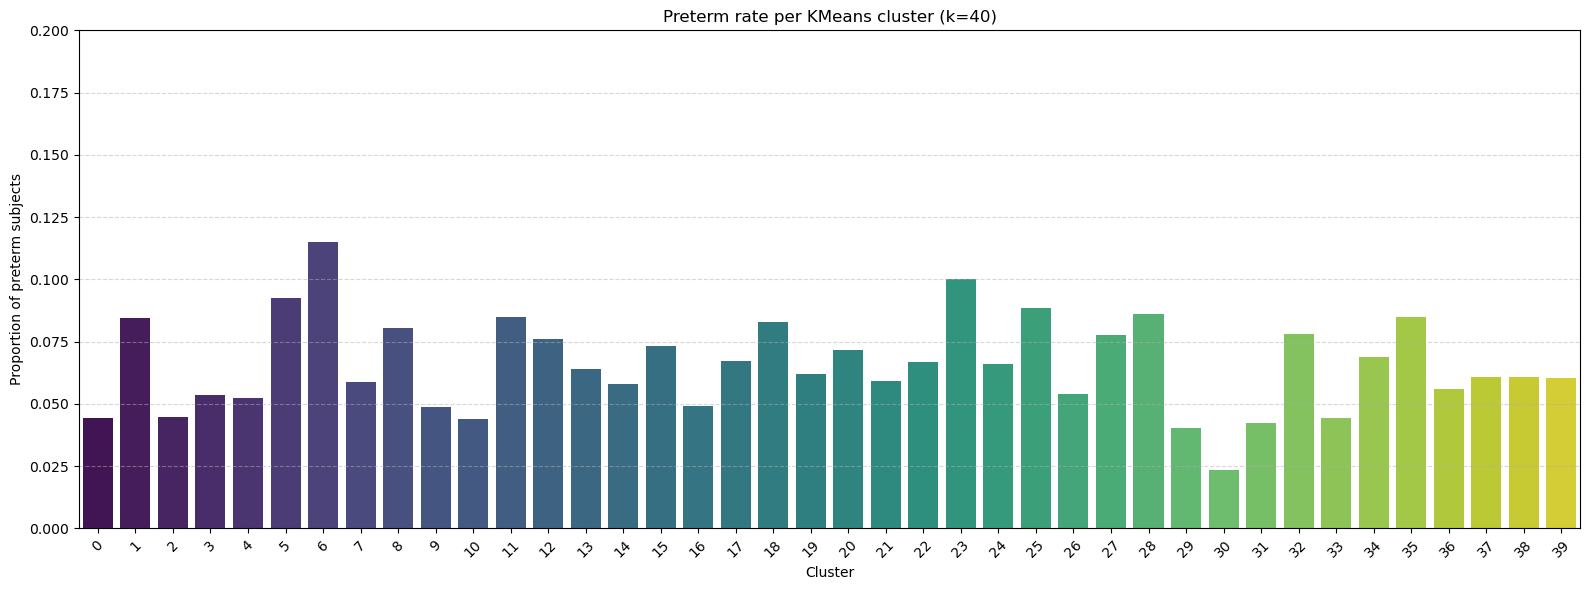

In [13]:
# Compute the prematurity rate
cluster_stats = (
    df.groupby('cluster_fixed250')['y']
    .agg(['count', 'sum'])
    .rename(columns={'count': 'n_subjects', 'sum': 'n_preterms'})
)
cluster_stats['preterm_rate'] = cluster_stats['n_preterms'] / cluster_stats['n_subjects']

for cluster in cluster_stats.index:
    print(f"Cluster {cluster}: {cluster_stats.loc[cluster, 'n_preterms']} preterm subjects out of {cluster_stats.loc[cluster, 'n_subjects']} ({cluster_stats.loc[cluster, 'preterm_rate']:.2%})")

# Visualisation
plt.figure(figsize=(16, 6))
sns.barplot(x=cluster_stats.index, y=cluster_stats['preterm_rate'],palette='viridis')
plt.ylabel("Proportion of preterm subjects")
plt.xlabel("Cluster")
plt.title("Preterm rate per KMeans cluster (k=40)")
plt.xticks(rotation=45)
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [254]:
clustered_df = df[['src_subject_id', 'y', 'cluster_kmeans']].copy()

# Prematurity rates by cluster
preterm_rates = (
    clustered_df.groupby('cluster_kmeans')['y']
    .mean()
    .sort_values(ascending=False)
)

# Create a new column with the rank of prematurity rates
ranked_clusters = {cluster: rank for rank, cluster in enumerate(preterm_rates.index)}
clustered_df['cluster_ranked'] = clustered_df['cluster_kmeans'].map(ranked_clusters)

# Sort the DataFrame by the ranked clusters
clustered_df = clustered_df.sort_values(by=['cluster_ranked'])

# Save the clustered DataFrame to a CSV file
clustered_df.to_csv("clustered_subjects_by_preterm_rate_FCMpost-SpC_right.csv", index=False)
